<a href="https://colab.research.google.com/github/Lambdaderta/yandex_lms_contest_ResNet/blob/main/ResNetik.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка датасета и библиотек

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

ml_intensive_yandex_academy_spring_2025_path = kagglehub.competition_download('ml-intensive-yandex-academy-spring-2025')

print('Data source import complete.')


100%|██████████| 7.90G/7.90G [05:58<00:00, 23.7MB/s]

Extracting files...


Data source import complete.


In [ ]:
!ls /root/.cache/kagglehub/competitions/ml-intensive-yandex-academy-spring-2025/human_poses_data/

activity_categories.csv  img_test  img_train  train_answers.csv


In [ ]:
!pip install --upgrade pillow pandas torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 118.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

# Импорт библиотек

In [ ]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
from torchvision import transforms
from sklearn.metrics import f1_score
import numpy as np
from torchsummary import summary
from google.colab import drive
import shutil

# Baseline обработки картинок

Как выяснилоь, было необходимо предсказывать не 20 классов, а 16, т.к. 4 из этих 20 просто не имели ни одного примера. Однако гораздо критичнее влиял баланс классов, ибо были классы по количеству примеров в несколько раз больше других.

In [ ]:
# Класс для трейновых данных
class TrainDataset(Dataset):
    def __init__(self, img_dir, csv_path, transform=None):
        self.img_dir = img_dir
        self.df = pd.read_csv(csv_path)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_id = str(self.df.iloc[idx, 0])
        img_name = os.path.join(self.img_dir, f"{file_id}.jpg")

        image = Image.open(img_name).convert('RGB')
        label = self.df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

# Класс для Тестовых данных

class TestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.img_list = os.listdir(img_dir)
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.img_list[idx])
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image


# Константы


DATA_DIR = "/root/.cache/kagglehub/competitions/ml-intensive-yandex-academy-spring-2025/human_poses_data"
CSV_PATH = os.path.join(DATA_DIR, 'train_answers.csv')
IMG_DIR = os.path.join(DATA_DIR, 'img_train')
TEST_DIR = os.path.join(DATA_DIR, 'img_test')

# Трансформация изображений

transform = transforms.Compose([
    transforms.Resize((896, 896)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = TrainDataset(
    img_dir=IMG_DIR,
    csv_path=CSV_PATH,
    transform=transform
)

labels = train_dataset.df.iloc[:, 1].tolist()

# Разделение данных на валидационные и трейновые

train_idx, val_idx = train_test_split(
    range(len(labels)),
    test_size=0.2,
    stratify=labels,
    random_state=42
)

train_subset = Subset(train_dataset, train_idx)
val_subset = Subset(train_dataset, val_idx)

test_dataset = TestDataset(
    img_dir=TEST_DIR,
    transform=transform
)

BATCH_SIZE = 32
NUM_WORKERS = 2

train_loader = DataLoader(
    train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

val_loader = DataLoader(
    val_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

# Архитектура модели



---

**Будет использована модель ResNet-18 с SEblock, для повышения точности при помощи механизма канального внимания**


---

Канальное внимание помогает модели классифицировать данные лучше, т.к. SEBlock динамически вычисляет веса для каждого канала, фокусируясь на важных.


---



In [ ]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16, dropout_p=0.2):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_p),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = x.mean((2, 3))
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


# Блок для построения архитектуры


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, dropout_p=0.3):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout_p)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion*out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion*out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(self.expansion*out_channels)
            )
        self.se = SEBlock(out_channels, dropout_p=dropout_p)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out = self.se(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out


# Основаня архитектура


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes, dropout_p=0.3):
        super().__init__()
        self.in_channels = 64
        self.dropout_p = dropout_p

        self.conv1 = nn.Conv2d(3, 64, 7, 2, 3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(3, 2, 1)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], 1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], 2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], 2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], 2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout_p)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride, self.dropout_p))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Функция обучения

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=30, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []
    train_f1, val_f1 = [], []
    best_f1 = 0.0

    drive.mount('/content/drive')
    drive_folder = '/content/drive/MyDrive/Colab Models'
    !mkdir -p "{drive_folder}"

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        epoch_f1 = f1_score(all_labels, all_preds, average='macro')
        train_f1.append(epoch_f1)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_loss = val_loss / len(val_loader)
        val_epoch_f1 = f1_score(val_labels, val_preds, average='macro')
        val_f1.append(val_epoch_f1)
        val_losses.append(val_loss)

        if val_epoch_f1 > best_f1:
            best_f1 = val_epoch_f1
            torch.save(model.state_dict(), 'best_model.pth')
            model_source = 'best_model.pth'
            drive_folder = '/content/drive/MyDrive/Colab Models'
            model_destination = f'{drive_folder}/best_model.pth'
            shutil.copy(model_source, model_destination)
            print(f'New best model saved! F1: {best_f1:.4f}')

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')
        print(f'Train F1: {epoch_f1:.4f} | Val F1: {val_epoch_f1:.4f}')
        print('-' * 60)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss Curves')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_f1, label='Train F1')
    plt.plot(val_f1, label='Val F1')
    plt.title('F1 Score Curves')
    plt.legend()

    plt.show()

    return model

# Вывод summary модели

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ResNet(BasicBlock, [2,2,2,2], num_classes=16).to(device)

print(summary(
    model,
    input_size=(3, 896, 896),
    device='cuda'
))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 448, 448]           9,408
       BatchNorm2d-2         [-1, 64, 448, 448]             128
              ReLU-3         [-1, 64, 448, 448]               0
         MaxPool2d-4         [-1, 64, 224, 224]               0
            Conv2d-5         [-1, 64, 224, 224]          36,864
       BatchNorm2d-6         [-1, 64, 224, 224]             128
              ReLU-7         [-1, 64, 224, 224]               0
           Dropout-8         [-1, 64, 224, 224]               0
            Conv2d-9         [-1, 64, 224, 224]          36,864
      BatchNorm2d-10         [-1, 64, 224, 224]             128
           Linear-11                    [-1, 4]             260
             ReLU-12                    [-1, 4]               0
          Dropout-13                    [-1, 4]               0
           Linear-14                   

# Обучение модели

## 1 Этап

начало обучения, но т.к. ресурсы ограничены этапов будет несколько.

In [ ]:
train_model(model, train_loader, val_loader, num_epochs=50, lr=0.001)

New best model saved! F1: 0.1332
Epoch [1/50]
Train Loss: 2.3704 | Val Loss: 2.2786
Train F1: 0.1127 | Val F1: 0.1332
------------------------------------------------------------
New best model saved! F1: 0.1392
Epoch [2/50]
Train Loss: 2.2442 | Val Loss: 2.2835
Train F1: 0.1505 | Val F1: 0.1392
------------------------------------------------------------
New best model saved! F1: 0.1703
Epoch [3/50]
Train Loss: 2.1736 | Val Loss: 2.1373
Train F1: 0.1778 | Val F1: 0.1703
------------------------------------------------------------
New best model saved! F1: 0.1979
Epoch [4/50]
Train Loss: 2.0972 | Val Loss: 2.0896
Train F1: 0.2027 | Val F1: 0.1979
------------------------------------------------------------
New best model saved! F1: 0.2359
Epoch [5/50]
Train Loss: 2.0289 | Val Loss: 1.9858
Train F1: 0.2240 | Val F1: 0.2359
------------------------------------------------------------
New best model saved! F1: 0.2496
Epoch [6/50]
Train Loss: 1.9675 | Val Loss: 1.9544
Train F1: 0.2365 | Va

## 2 Этап

Продолжаем учить. Загружаем лучшую модель и поехали.

In [ ]:
model.load_state_dict(torch.load('best_model(1).pth'))

<All keys matched successfully>

In [ ]:
train_model(model, train_loader, val_loader, num_epochs=50, lr=0.001)

New best model saved! F1: 0.3913
Epoch [1/50]
Train Loss: 1.5075 | Val Loss: 1.6905
Train F1: 0.4222 | Val F1: 0.3913
------------------------------------------------------------
Epoch [2/50]
Train Loss: 1.4598 | Val Loss: 1.6560
Train F1: 0.4395 | Val F1: 0.3912
------------------------------------------------------------
New best model saved! F1: 0.4549
Epoch [3/50]
Train Loss: 1.3735 | Val Loss: 1.4961
Train F1: 0.4700 | Val F1: 0.4549
------------------------------------------------------------
New best model saved! F1: 0.4638
Epoch [4/50]
Train Loss: 1.3334 | Val Loss: 1.4878
Train F1: 0.4906 | Val F1: 0.4638
------------------------------------------------------------
New best model saved! F1: 0.4705
Epoch [5/50]
Train Loss: 1.2612 | Val Loss: 1.4395
Train F1: 0.5223 | Val F1: 0.4705
------------------------------------------------------------
New best model saved! F1: 0.4707
Epoch [6/50]
Train Loss: 1.2114 | Val Loss: 1.4710
Train F1: 0.5322 | Val F1: 0.4707
--------------------

KeyboardInterrupt: 

Ресурсы закончились, поэтому будут еще этапы дообучения, но можно попробовать что то предиктнуть)

## 3 этап обучения, с аугментацией

Все тоже самое, но в этот раз добавим аугментацю, чтобы модель не расслаблялась.

In [ ]:
model.load_state_dict(torch.load('best_model(4).pth')) # Загрузка лучшей модели

<All keys matched successfully>

Создание даталоадеров с аугами

In [ ]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from sklearn.model_selection import train_test_split

class TrainDataset(Dataset):
    def __init__(self, img_dir, csv_path, transform=None):
        self.img_dir = img_dir
        self.df = pd.read_csv(csv_path)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_id = str(self.df.iloc[idx, 0])
        img_name = os.path.join(self.img_dir, f"{file_id}.jpg")

        image = Image.open(img_name).convert('RGB')
        label = self.df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

class TestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.img_list = os.listdir(img_dir)
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.img_list[idx])
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

DATA_DIR = "/root/.cache/kagglehub/competitions/ml-intensive-yandex-academy-spring-2025/human_poses_data"
CSV_PATH = os.path.join(DATA_DIR, 'train_answers.csv')
IMG_DIR = os.path.join(DATA_DIR, 'img_train')
TEST_DIR = os.path.join(DATA_DIR, 'img_test')

train_transform = transforms.Compose([
    transforms.Resize((896, 896)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((896, 896)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = TrainDataset(
    img_dir=IMG_DIR,
    csv_path=CSV_PATH,
    transform=train_transform
)

labels = train_dataset.df.iloc[:, 1].tolist()
train_idx, val_idx = train_test_split(
    range(len(labels)),
    test_size=0.2,
    stratify=labels,
    random_state=42
)

train_subset = Subset(train_dataset, train_idx)
val_subset = Subset(train_dataset, val_idx)

val_subset.dataset.transform = val_test_transform

test_dataset = TestDataset(
    img_dir=TEST_DIR,
    transform=val_test_transform
)

BATCH_SIZE = 32
NUM_WORKERS = 2

train_loader = DataLoader(
    train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

val_loader = DataLoader(
    val_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)


In [ ]:
train_model(model, train_loader, val_loader, num_epochs=20, lr=0.001)

New best model saved! F1: 0.6317
Epoch [1/20]
Train Loss: 0.3525 | Val Loss: 1.4586
Train F1: 0.8602 | Val F1: 0.6317
------------------------------------------------------------
Epoch [2/20]
Train Loss: 0.3112 | Val Loss: 1.4913
Train F1: 0.8764 | Val F1: 0.6236
------------------------------------------------------------
Epoch [3/20]
Train Loss: 0.2908 | Val Loss: 1.4445
Train F1: 0.8919 | Val F1: 0.6297
------------------------------------------------------------
New best model saved! F1: 0.6594
Epoch [4/20]
Train Loss: 0.2821 | Val Loss: 1.3492
Train F1: 0.8820 | Val F1: 0.6594
------------------------------------------------------------
Epoch [5/20]
Train Loss: 0.2850 | Val Loss: 1.4239
Train F1: 0.8936 | Val F1: 0.6408
------------------------------------------------------------
Epoch [6/20]
Train Loss: 0.2584 | Val Loss: 1.5167
Train F1: 0.8932 | Val F1: 0.6400
------------------------------------------------------------
New best model saved! F1: 0.6632
Epoch [7/20]
Train Loss: 

## 4 этап обучения

И как выяснилось последний.

In [ ]:
model.load_state_dict(torch.load('best_model.pth')) # Загрузка лучшей модели

<All keys matched successfully>

In [ ]:
train_model(model, train_loader, val_loader, num_epochs=20, lr=0.0005)

Mounted at /content/drive
New best model saved! F1: 0.6919
Epoch [1/20]
Train Loss: 0.0696 | Val Loss: 1.4384
Train F1: 0.9785 | Val F1: 0.6919
------------------------------------------------------------
Epoch [2/20]
Train Loss: 0.0745 | Val Loss: 1.4544
Train F1: 0.9772 | Val F1: 0.6885
------------------------------------------------------------
New best model saved! F1: 0.7057
Epoch [3/20]
Train Loss: 0.0757 | Val Loss: 1.3589
Train F1: 0.9769 | Val F1: 0.7057
------------------------------------------------------------
Epoch [4/20]
Train Loss: 0.0574 | Val Loss: 1.4661
Train F1: 0.9797 | Val F1: 0.6940
------------------------------------------------------------
Epoch [5/20]
Train Loss: 0.0578 | Val Loss: 1.4639
Train F1: 0.9779 | Val F1: 0.6868
------------------------------------------------------------
Epoch [6/20]
Train Loss: 0.0559 | Val Loss: 1.4651
Train F1: 0.9791 | Val F1: 0.6944
------------------------------------------------------------
New best model saved! F1: 0.7147

В общем лучше 0.7 я ничего получить не смог, было еще 2 попытки дообучить, но тщетно, так что могу сделать вывод, что это пик моего резнетика.

# Предикт на тесте

In [ ]:
import torch
import pandas as pd
from PIL import Image
import os

def predict_test_set(model, test_loader, device='cuda'):
    model.eval()
    model.to(device)
    all_preds = []
    filenames = []

    with torch.no_grad():
        for images, paths in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            filenames.extend(paths)

    return filenames, all_preds

model = ResNet(BasicBlock, [2,2,2,2], num_classes=16)
model.load_state_dict(torch.load('best_model(7).pth'))

class CustomTestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = TEST_DIR
        self.img_list = os.listdir(TEST_DIR)
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.img_list[idx])
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, self.img_list[idx]

test_dataset = CustomTestDataset(
    img_dir='img_test',
    transform=val_test_transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

filenames, predictions = predict_test_set(model, test_loader)

results_df = pd.DataFrame({
    'id': filenames,
    'target_feature': predictions
})

results_df['id'] = results_df['id'].str.replace(r'\.jpg$', '', regex=True)

results_df.to_csv('predictions.csv', index=False)

# Вывод



---



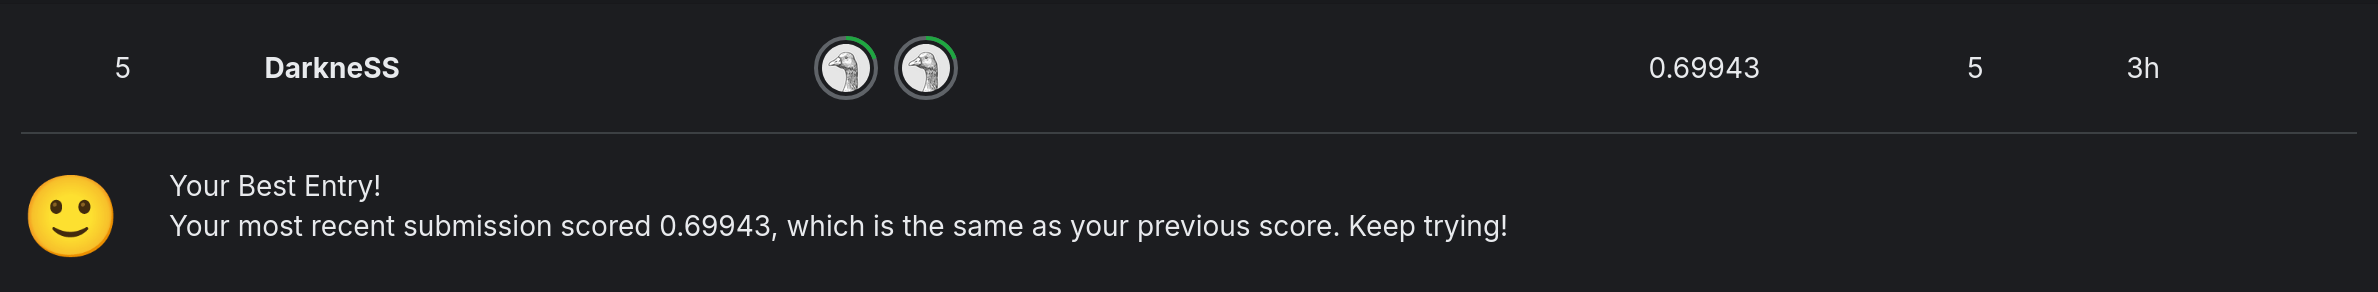



---


В общем пик моей модели - f1-score = 0.7. Вполне неплохо, хотя можно куда лучше. Потом возможно загружу ноутбук с более продвинутой и крутой архитектурой, а также получше обработанными классами.


---



# Другие попытки



---


Была попытка написать ViT для классификации, с улучшенной обработкой классов ну и крутой архитектурой трансформеров, однако времени было мало и модель просто переобучилась.


---


Ссылка на ноутбук для изучения - https://colab.research.google.com/drive/1Me3Nz83pOOLFRxiPm488a61gShPoFZNz?usp=sharing


---

